In [3]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import cv2

In [4]:
dataset_dir = "/kaggle/input/arabic-letters-numbers-ocr/Dataset"

# Extract unique characters from directory names
unique_chars = set()
for label in os.listdir(dataset_dir):
    unique_chars.add(label)


In [62]:
# create a mapping for each char
char_to_num = {char: idx for idx, char in enumerate(sorted(unique_chars))}
print("Characters:", sorted(unique_chars))
print("Character to number mapping:", char_to_num)

Characters: ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'لا', 'م', 'ن', 'ه', 'و', 'ي', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩']
Character to number mapping: {'ا': 0, 'ب': 1, 'ت': 2, 'ث': 3, 'ج': 4, 'ح': 5, 'خ': 6, 'د': 7, 'ذ': 8, 'ر': 9, 'ز': 10, 'س': 11, 'ش': 12, 'ص': 13, 'ض': 14, 'ط': 15, 'ظ': 16, 'ع': 17, 'غ': 18, 'ف': 19, 'ق': 20, 'ك': 21, 'ل': 22, 'لا': 23, 'م': 24, 'ن': 25, 'ه': 26, 'و': 27, 'ي': 28, '٠': 29, '١': 30, '٢': 31, '٣': 32, '٤': 33, '٥': 34, '٦': 35, '٧': 36, '٨': 37, '٩': 38}


In [63]:
char_to_num['لا']

23

In [66]:
#get all the images paths and their labels then open and resize the image using opencv
data=[]
labels = []

for folder in os.listdir(dataset_dir):
    images = os.listdir(os.path.join(dataset_dir,folder))
    for img in images:
        img_path = os.path.join(dataset_dir,folder,img)
        img = cv2.imread(img_path,0) # Read image in grayscale
        if img is None:
            print(f"Error reading image: {img_path}")
            continue
        img = cv2.resize(img,(32,32)) # Resize image
        data.append(img)
        labels.append(char_to_num[folder])



Error reading image: /kaggle/input/arabic-letters-numbers-ocr/Dataset/ل/main.py


In [67]:
print(len(data),len(labels))

96749 96749


In [68]:
# convert the data and labels list into numpy array 
data = np.array(data) / 255.0 # normalize the images
labels = np.array(labels)
data.shape

(96749, 32, 32)

In [69]:
data= np.expand_dims(data, axis=-1) # Add a channel dimension
data.shape

(96749, 32, 32, 1)

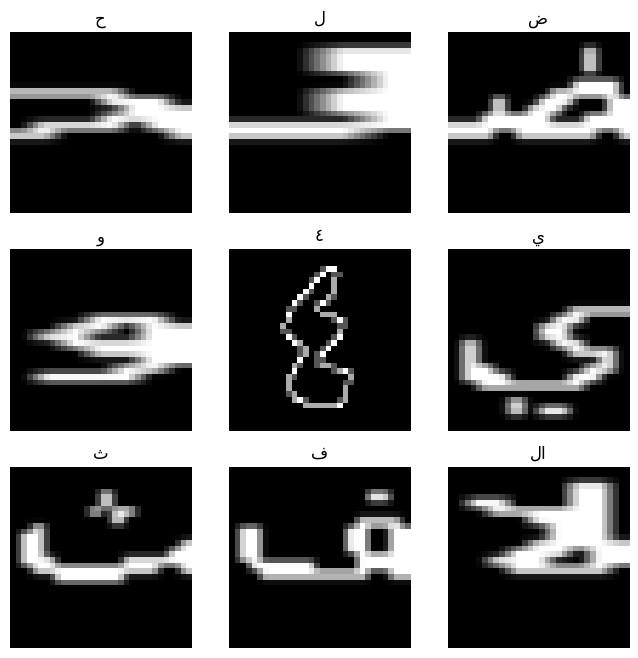

In [83]:
plt.figure(figsize=(8,8))
for i, v in enumerate(np.random.randint(0,len(data),9)):
    plt.subplot(3,3,i+1)
    plt.imshow(data[v],cmap='gray')
    label = next(key for key,value in char_to_num.items() if value == labels[v] ) # reverse lookup in the chars dic 
    plt.title(label)
    plt.axis("off")


In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping

In [87]:
from sklearn.utils import shuffle

data,labels = shuffle(data,labels,random_state=42)

In [88]:
# split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

In [89]:
# split the train data into trian and validation
X_train, X_val, y_train , y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=42)

In [90]:
print(len(X_train),len(X_test),len(X_val))

58049 19350 19350


In [91]:
X_train.shape

(58049, 32, 32, 1)

In [215]:
# Define Model 
INPUT_SHAPE = (32,32,1)
EPOCHS = 10
BATCH_SIZE = 16
NUM_CLASSES = 39  # arabic chars and numbers 

# Custom Model Definition
input_layer = Input(shape=INPUT_SHAPE)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)


# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 39)             │        20,007 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,136,871 (8.15 MB)

 Trainable params: 2,136,679 (8.15 MB)

 Non-trainable params: 192 (768.00 B)

In [217]:
# Define early stopping callback
callback = EarlyStopping(monitor='val_loss', mode='min',patience=3,verbose=1) 

# Train the model
history = model.fit(X_train,y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = (X_val,y_val),
                    callbacks=[callback]
)



Epoch 1/10
  61/3629 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.3012 - loss: 3.9756    

W0000 00:00:1719179528.861264     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3629/3629 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8395 - loss: 0.6211

W0000 00:00:1719179541.512403     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3629/3629 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8396 - loss: 0.6210 - val_accuracy: 0.9837 - val_loss: 0.0573
Epoch 2/10
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9672 - loss: 0.1257 - val_accuracy: 0.9884 - val_loss: 0.0412
Epoch 3/10
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9778 - loss: 0.0911 - val_accuracy: 0.9930 - val_loss: 0.0354
Epoch 4/10
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0608 - val_accuracy: 0.9933 - val_loss: 0.0266
Epoch 5/10
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9871 - loss: 0.0484 - val_accuracy: 0.9948 - val_loss: 0.0227
Epoch 6/10
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9900 - loss: 0.0359 - val_accuracy: 0.9957 - val_loss: 0.0187
Epoch 7/10
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9899 - loss: 0.0342 - val_accuracy: 0.9970 - val_loss: 0.0163
Epoch 8/10
3629/3629 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9935 - loss: 0.0238 - val

In [218]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {round(test_loss,2)}')
print(f'Test accuracy: {round(test_accuracy,2)}')

 92/605 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0178    

W0000 00:00:1719179640.206356     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9964 - loss: 0.0184
Test loss: 0.02
Test accuracy: 1.0


W0000 00:00:1719179641.442515     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


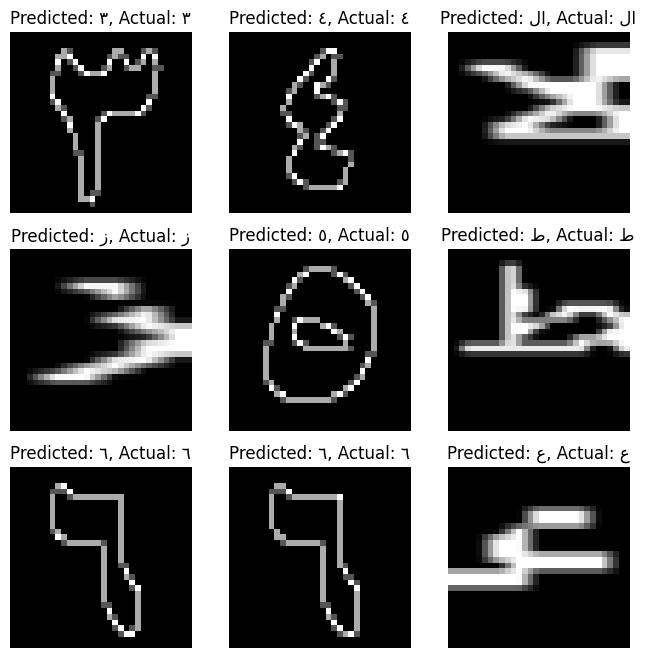

In [219]:
plt.figure(figsize=(8,8))
for i,v in enumerate(np.random.randint(0,len(X_test),9)):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[v],cmap='gray')
    input_data = np.expand_dims(X_test[v],axis=0)
    predictions = model.predict(input_data)
    predicted_class = np.argmax(predictions)
    predict = next(key for key, value in char_to_num.items() if value == predicted_class)
    actual = next(key for key, value in char_to_num.items() if value == y_test[v])

    plt.title(f"Predicted: {predict}, Actual: {actual}")
    plt.axis('off')

In [220]:
model.save('arabic_char_ocr.h5')

## convert tensorflow model to onnx

In [99]:
%%capture
pip install tf2onnx

In [221]:
import tf2onnx
import tensorflow as tf

keras_model = load_model("arabic_char_ocr.h5")
# Convert the Keras model to ONNX
onnx_model_path = '/kaggle/working/arabic_char_ocr.onnx'

input_shape = (None, 32, 32, 1) 
spec = (tf.TensorSpec(input_shape, tf.float32, name="input_1"),)

# Convert the Keras model to ONNX
model_proto, _ = tf2onnx.convert.from_keras(
    keras_model, input_signature=spec, opset=13)

# Save the ONNX model to a file
with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())

In [101]:
%%capture 
pip install onnxruntime

In [222]:
import onnxruntime

# Load the ONNX model
onnx_model_path = '/kaggle/working/arabic_char_ocr.onnx'
onnx_session = onnxruntime.InferenceSession(onnx_model_path)

random_index = np.random.randint(0, len(X_test))
input_data = np.expand_dims(X_test[random_index],axis=0).astype(np.float32)

# Run inference
onnx_input = {onnx_session.get_inputs()[0].name: input_data}
onnx_output = onnx_session.run(None, onnx_input)

# Get predictions
predictions = onnx_output[0]
predicted_class = np.argmax(predictions)


In [223]:
predicted_class

28

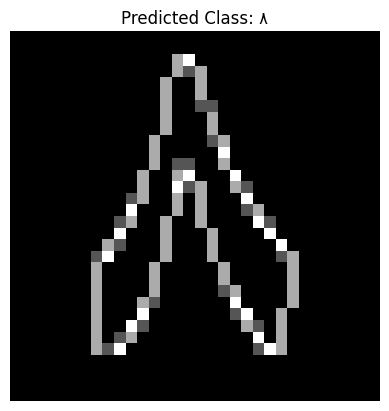

In [210]:
plt.imshow(X_test[random_index], cmap='gray')
character = next(key for key, value in char_to_num.items() if value == predicted_class)
plt.title(f"Predicted Class: {character}")
plt.axis('off')
plt.show()
